In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.dates as mdates

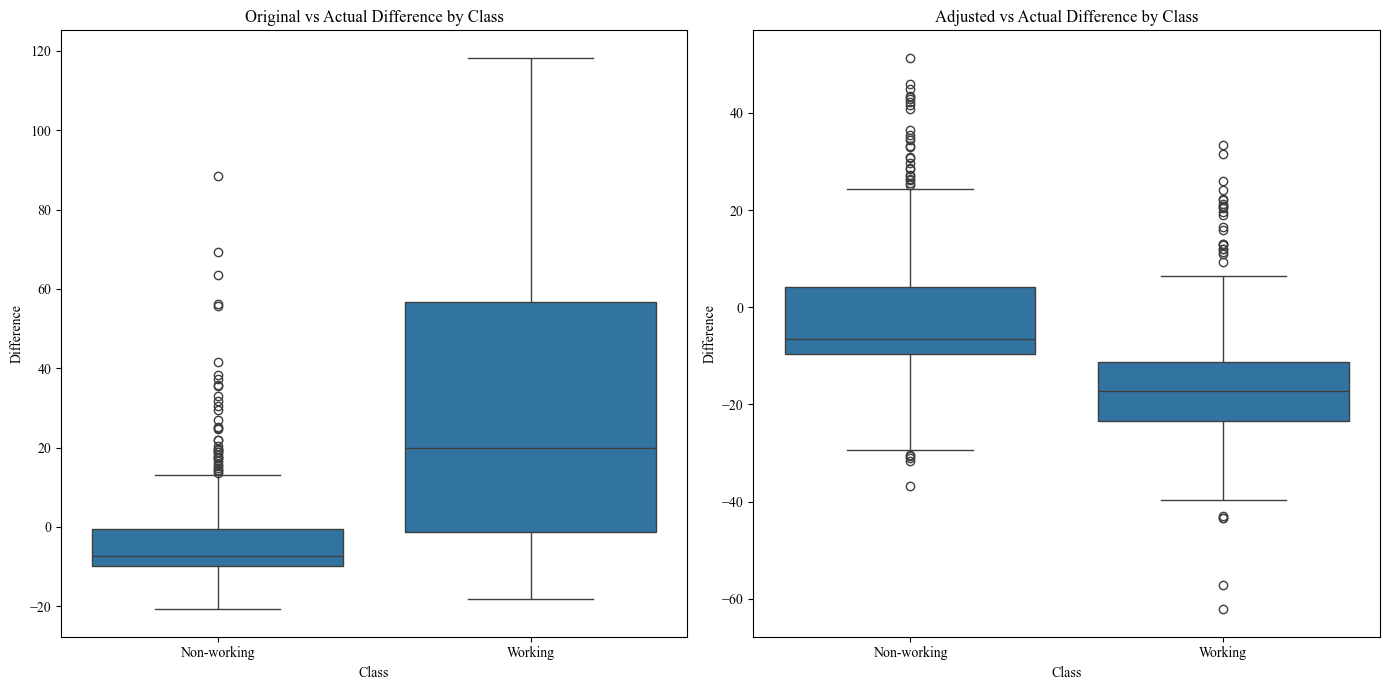

In [97]:
# 读取CSV文件
file_path = r"C:\Users\86180\OneDrive - University College London\Dissertation\Drawing for Mark Group House\Boiler energy.csv"
df = pd.read_csv(file_path)

# 生成从11月1日到11月18日的日期列表
start_date = datetime(2015, 11, 1)
end_date = datetime(2015, 11, 18)
date_range = pd.date_range(start_date, end_date, freq='D')

# 重复日期列表以匹配DataFrame的长度
dates = []
for date in date_range:
    dates.extend([date] * 24)  # 假设每天有24行数据，对应24小时

# 确保日期列表的长度与DataFrame相同
if len(dates) < len(df):
    additional_dates = [date_range[-1]] * (len(df) - len(dates))
    dates.extend(additional_dates)
elif len(dates) > len(df):
    dates = dates[:len(df)]

# 添加Date列到DataFrame
df['Date'] = dates

# 确保Time列中的时间格式一致，并转换为时间对象
df['Time'] = df['Time'].astype(str).str.strip()
df['Time'] = df['Time'].apply(lambda x: x if len(x) == 8 else f"{x}:00")
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# 添加weekday_end列
special_dates = ['2015-11-01', '2015-11-08', '2015-11-09', '2015-11-15', '2015-11-16']
df['weekday_end'] = df['Date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in special_dates else 0)

# 添加timework_rest列
start_work_time = datetime.strptime('08:30:00', '%H:%M:%S').time()
end_work_time = datetime.strptime('18:30:00', '%H:%M:%S').time()
df['timework_rest'] = df['Time'].apply(lambda x: 1 if start_work_time <= x <= end_work_time else 0)

# 添加Class列
def classify(row):
    if row['weekday_end'] == 1 or row['timework_rest'] == 0:
        return 'Non-working'
    else:
        return 'Working'

df['Class'] = df.apply(classify, axis=1)

# 计算差值
df['Original_vs_Actual_Diff'] = df['original_boiler_unit_value'] - df['actual_boiler_unit_value']
df['Adjusted_vs_Actual_Diff'] = df['adjusted_boiler_unit_value'] - df['actual_boiler_unit_value']

# 绘制箱线图
plt.figure(figsize=(14, 7))

# 原始模型的箱线图
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Original_vs_Actual_Diff', data=df)
plt.title('Original vs Actual Difference by Class')
plt.xlabel('Class')
plt.ylabel('Difference')

# 调整后模型的箱线图
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Adjusted_vs_Actual_Diff', data=df)
plt.title('Adjusted vs Actual Difference by Class')
plt.xlabel('Class')
plt.ylabel('Difference')

plt.tight_layout()
plt.show()

原始数据:
        Date  actual boiler unit  original boiler unit  adjust boiler unit
0  2015/11/1          351.467393               97.2413            124.3367
1  2015/11/2          443.747879              280.2537            260.0996
2  2015/11/3          470.645818              701.6083            309.9674
3  2015/11/4          490.107759              539.8000            472.0000
4  2015/11/5          410.615777              755.3000            227.3000
解析后的日期列:
0   2015-11-01
1   2015-11-02
2   2015-11-03
3   2015-11-04
4   2015-11-05
Name: Date, dtype: datetime64[ns]
处理后的日期范围:
2015-11-01 00:00:00 到 2015-11-18 00:00:00
处理后的数据:
            actual boiler unit  original boiler unit  adjust boiler unit
Date                                                                    
NaT                        NaN                   NaN                 NaN
2015-11-01          351.467393               97.2413            124.3367
2015-11-02          443.747879              280.2537            260.0996
2

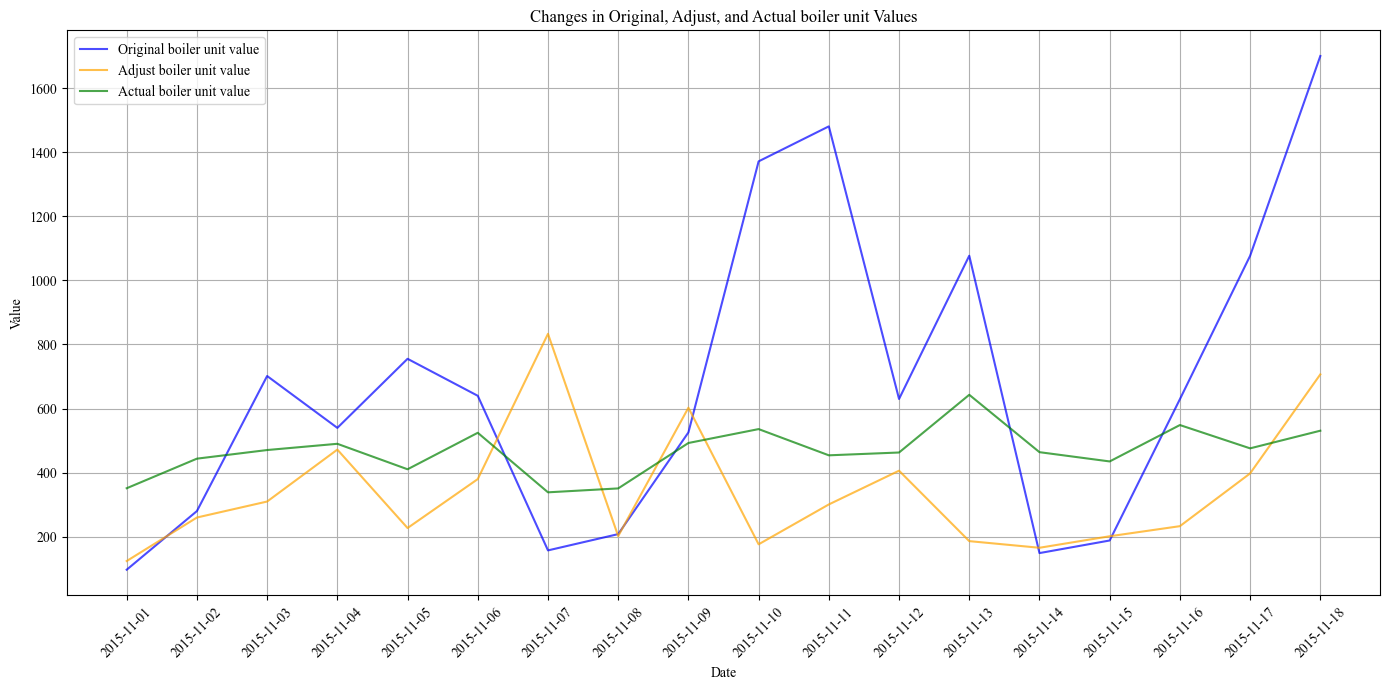

In [89]:
# 读取CSV文件
file_path = r"C:\Users\86180\OneDrive - University College London\Dissertation\Drawing for Mark Group House\boilerenergycomparison.csv"
df = pd.read_csv(file_path)

# 显示原始数据的前几行以确认数据内容
print("原始数据:")
print(df.head())

# 尝试解析日期列
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%Y/%m/%d')  # 使用适当的格式

# 确保数值列是数字类型
df['original boiler unit'] = pd.to_numeric(df['original boiler unit'], errors='coerce')
df['adjust boiler unit'] = pd.to_numeric(df['adjust boiler unit'], errors='coerce')
df['actual boiler unit'] = pd.to_numeric(df['actual boiler unit'], errors='coerce')

# 显示解析后的日期列
print("解析后的日期列:")
print(df['Date'].head())

# 设置日期列为索引
df.set_index('Date', inplace=True)

# 检查并删除重复的日期索引
df = df[~df.index.duplicated(keep='first')]

# 确保日期范围正确
print("处理后的日期范围:")
print(df.index.min(), "到", df.index.max())

# 重新索引以填补缺失的日期
df = df.resample('D').asfreq()  # 'D' 表示按天重采样

# 线性插值填补缺失值
df = df.interpolate()

# 显示处理后的数据
print("处理后的数据:")
print(df.head())

# 绘制图表
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['original boiler unit'], label='Original boiler unit value', color='blue', alpha=0.7)
plt.plot(df.index, df['adjust boiler unit'], label='Adjust boiler unit value', color='orange', alpha=0.7)
plt.plot(df.index, df['actual boiler unit'], label='Actual boiler unit value', color='green', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Changes in Original, Adjust, and Actual boiler unit Values')
plt.legend()
plt.grid(True)

# 设置日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # 如果日期间隔为天
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Original_vs_Actual_Diff - Q1: -9.343830982499998
Original_vs_Actual_Diff - Q3: 16.5712565825
Original_vs_Actual_Diff - IQR: 25.915087564999997
Original_vs_Actual_Diff - Lower Bound: -48.21646233
Original_vs_Actual_Diff - Upper Bound: 55.443887929999995
Adjusted_vs_Actual_Diff - Q1: -15.173230250000001
Adjusted_vs_Actual_Diff - Q3: 0.08293575499999939
Adjusted_vs_Actual_Diff - IQR: 15.256166005
Adjusted_vs_Actual_Diff - Lower Bound: -38.057479257500006
Adjusted_vs_Actual_Diff - Upper Bound: 22.967184762500004
Large difference in Original: Date = 2015-11-03, Time = 15:30:00
Large difference in Original: Date = 2015-11-03, Time = 16:30:00
Large difference in Original: Date = 2015-11-10, Time = 12:30:00
Large difference in Original: Date = 2015-11-10, Time = 13:30:00
Large difference in Original: Date = 2015-11-10, Time = 14:30:00
Large difference in Original: Date = 2015-11-10, Time = 15:30:00
Large difference in Original: Date = 2015-11-10, Time = 16:30:00
Large difference in Original: D

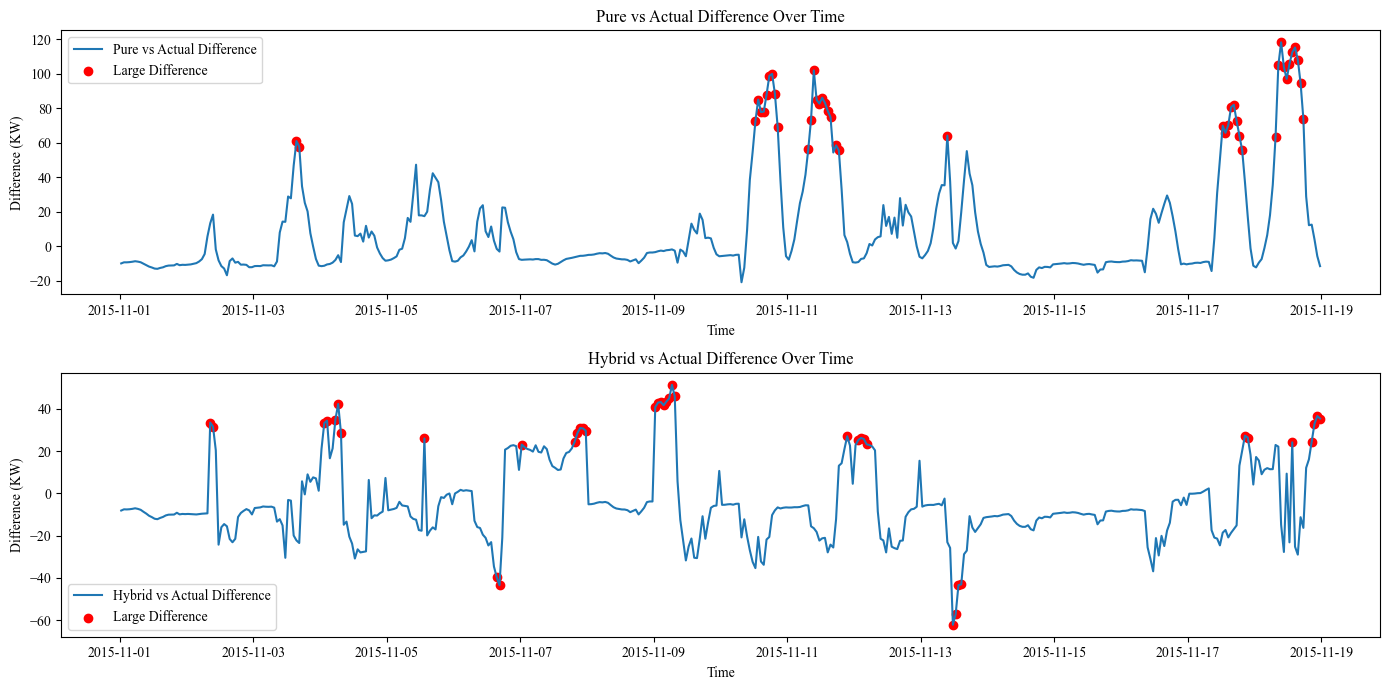

In [109]:
# 读取CSV文件
file_path = r"C:\Users\86180\OneDrive - University College London\Dissertation\Drawing for Mark Group House\Boiler energy.csv"
df = pd.read_csv(file_path)

# 生成从11月1日到11月18日的日期列表
start_date = datetime(2015, 11, 1)
end_date = datetime(2015, 11, 18)
date_range = pd.date_range(start_date, end_date, freq='D')

# 重复日期列表以匹配DataFrame的长度
dates = []
for date in date_range:
    dates.extend([date] * 24)  # 假设每天有24行数据，对应24小时

# 确保日期列表的长度与DataFrame相同
if len(dates) < len(df):
    additional_dates = [date_range[-1]] * (len(df) - len(dates))
    dates.extend(additional_dates)
elif len(dates) > len(df):
    dates = dates[:len(df)]

# 添加Date列到DataFrame
df['Date'] = dates

# 确保Time列中的时间格式一致，并转换为时间对象
df['Time'] = df['Time'].astype(str).str.strip()
df['Time'] = df['Time'].apply(lambda x: x if len(x) == 8 else f"{x}:00")
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# 添加weekday_end列
special_dates = ['2015-11-01', '2015-11-08', '2015-11-09', '2015-11-15', '2015-11-16']
df['weekday_end'] = df['Date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in special_dates else 0)

# 添加timework_rest列
start_work_time = datetime.strptime('08:30:00', '%H:%M:%S').time()
end_work_time = datetime.strptime('18:30:00', '%H:%M:%S').time()
df['timework_rest'] = df['Time'].apply(lambda x: 1 if start_work_time <= x <= end_work_time else 0)

# 添加Class列
def classify(row):
    if row['weekday_end'] == 1 or row['timework_rest'] == 0:
        return 'Non-working'
    else:
        return 'Working'

df['Class'] = df.apply(classify, axis=1)

# 计算差值
df['Original_vs_Actual_Diff'] = df['original_boiler_unit_value'] - df['actual_boiler_unit_value']
df['Adjusted_vs_Actual_Diff'] = df['adjusted_boiler_unit_value'] - df['actual_boiler_unit_value']

# 计算四分位距 (IQR) 方法来识别“大差异”
def detect_large_differences(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (df[column_name] < lower_bound) | (df[column_name] > upper_bound)

# 应用IQR方法来识别“大差异”
df['Large_Difference_Original'] = detect_large_differences(df, 'Original_vs_Actual_Diff')
df['Large_Difference_Adjusted'] = detect_large_differences(df, 'Adjusted_vs_Actual_Diff')

# 打印四分位数、IQR及阈值
def print_iqr_info(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    print(f"{column_name} - Q1: {Q1}")
    print(f"{column_name} - Q3: {Q3}")
    print(f"{column_name} - IQR: {IQR}")
    print(f"{column_name} - Lower Bound: {Q1 - 1.5 * IQR}")
    print(f"{column_name} - Upper Bound: {Q3 + 1.5 * IQR}")

print_iqr_info(df, 'Original_vs_Actual_Diff')
print_iqr_info(df, 'Adjusted_vs_Actual_Diff')

# 打印异常值的具体时间
def print_large_differences_info(df, column_name):
    large_diff_df = df[df[f'Large_Difference_{column_name}']]
    for idx, row in large_diff_df.iterrows():
        print(f"Large difference in {column_name}: Date = {row['Date'].strftime('%Y-%m-%d')}, Time = {row['Time']}")

print_large_differences_info(df, 'Original')
print_large_differences_info(df, 'Adjusted')

# 绘制时间序列图
plt.figure(figsize=(14, 7))

# 原始模型的时间序列图
plt.subplot(2, 1, 1)
plt.plot(df['Date'] + pd.to_timedelta(df['Time'].astype(str)), df['Original_vs_Actual_Diff'], label='Pure vs Actual Difference')
plt.scatter(df[df['Large_Difference_Original']]['Date'] + pd.to_timedelta(df[df['Large_Difference_Original']]['Time'].astype(str)),
            df[df['Large_Difference_Original']]['Original_vs_Actual_Diff'], color='red', label='Large Difference', marker='o')
plt.title('Pure vs Actual Difference Over Time')
plt.xlabel('Time')
plt.ylabel('Difference (KW)')
plt.legend()

# 调整后模型的时间序列图
plt.subplot(2, 1, 2)
plt.plot(df['Date'] + pd.to_timedelta(df['Time'].astype(str)), df['Adjusted_vs_Actual_Diff'], label='Hybrid vs Actual Difference')
plt.scatter(df[df['Large_Difference_Adjusted']]['Date'] + pd.to_timedelta(df[df['Large_Difference_Adjusted']]['Time'].astype(str)),
            df[df['Large_Difference_Adjusted']]['Adjusted_vs_Actual_Diff'], color='red', label='Large Difference', marker='o')
plt.title('Hybrid vs Actual Difference Over Time')
plt.xlabel('Time')
plt.ylabel('Difference (KW)')
plt.legend()

plt.tight_layout()
plt.show()

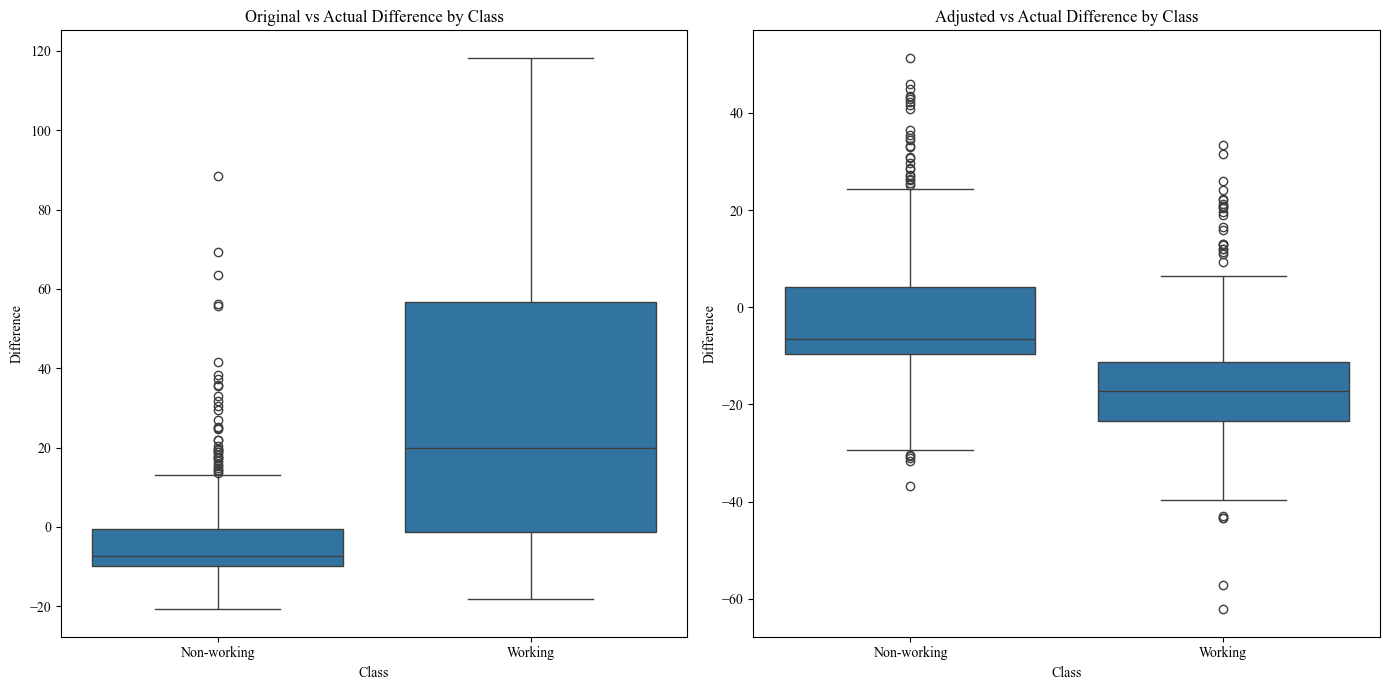

In [ ]:
# 读取CSV文件
file_path = r"C:\Users\86180\OneDrive - University College London\Dissertation\Drawing for Mark Group House\Boiler energy.csv"
df = pd.read_csv(file_path)

# 生成从11月1日到11月18日的日期列表
start_date = datetime(2015, 11, 1)
end_date = datetime(2015, 11, 18)
date_range = pd.date_range(start_date, end_date, freq='D')

# 重复日期列表以匹配DataFrame的长度
dates = []
for date in date_range:
    dates.extend([date] * 24)  # 假设每天有24行数据，对应24小时

# 确保日期列表的长度与DataFrame相同
if len(dates) < len(df):
    additional_dates = [date_range[-1]] * (len(df) - len(dates))
    dates.extend(additional_dates)
elif len(dates) > len(df):
    dates = dates[:len(df)]

# 添加Date列到DataFrame
df['Date'] = dates

# 确保Time列中的时间格式一致，并转换为时间对象
df['Time'] = df['Time'].astype(str).str.strip()
df['Time'] = df['Time'].apply(lambda x: x if len(x) == 8 else f"{x}:00")
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# 添加weekday_end列
special_dates = ['2015-11-01', '2015-11-08', '2015-11-09', '2015-11-15', '2015-11-16']
df['weekday_end'] = df['Date'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in special_dates else 0)

# 添加timework_rest列
start_work_time = datetime.strptime('08:30:00', '%H:%M:%S').time()
end_work_time = datetime.strptime('18:30:00', '%H:%M:%S').time()
df['timework_rest'] = df['Time'].apply(lambda x: 1 if start_work_time <= x <= end_work_time else 0)

# 添加Class列
def classify(row):
    if row['weekday_end'] == 1 or row['timework_rest'] == 0:
        return 'Non-working'
    else:
        return 'Working'

df['Class'] = df.apply(classify, axis=1)

# 计算差值
df['Original_vs_Actual_Diff'] = df['original_boiler_unit_value'] - df['actual_boiler_unit_value']
df['Adjusted_vs_Actual_Diff'] = df['adjusted_boiler_unit_value'] - df['actual_boiler_unit_value']

# 绘制箱线图
plt.figure(figsize=(14, 7))

# 原始模型的箱线图
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Original_vs_Actual_Diff', data=df)
plt.title('Original vs Actual Difference by Class')
plt.xlabel('Class')
plt.ylabel('Difference')

# 调整后模型的箱线图
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Adjusted_vs_Actual_Diff', data=df)
plt.title('Adjusted vs Actual Difference by Class')
plt.xlabel('Class')
plt.ylabel('Difference')

plt.tight_layout()
plt.show()